# Solving IK of a Robot Leg

These few Lines of Python-Code will solve the IK-Calculations for a Robot-Leg.

<IPython.core.display.Javascript object>


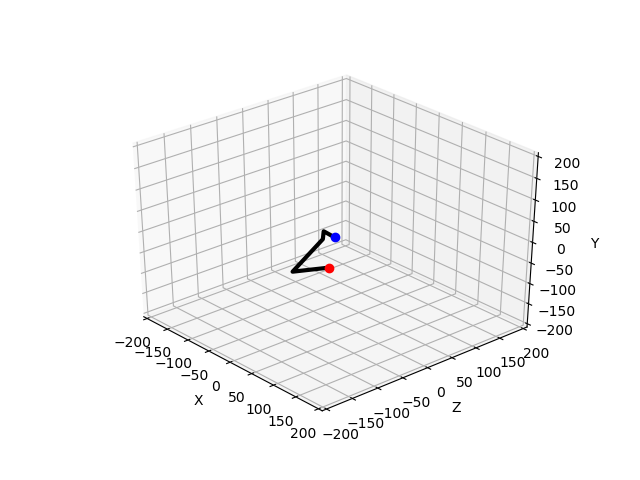

In [170]:
%matplotlib notebook

from mpl_toolkits import mplot3d
import  numpy as np
from math import *
import matplotlib.pyplot as plt

l1=25
l2=20
l3=80
l4=80

def legIK(x,y,z):
    
    """
    F=Length of shoulder-point to target-point on x/y only
    G=length we need to reach to the point on x/y
    H=3-Dimensional length we need to reach
    """

    F=sqrt(x**2+y**2-l1**2)
    G=F-l2  
    H=sqrt(G**2+z**2)

    theta1=-atan2(y,x)-atan2(F,-l1)
    
    D=(H**2-l3**2-l4**2)/(2*l3*l4)
    theta3=acos(D) 
    
    theta2=atan2(z,G)-atan2(l4*sin(theta3),l3+l4*cos(theta3))

    return(theta1,theta2,theta3)

def calcLegPoints(x,y,z):
    (theta1,theta2,theta3)=legIK(x,y,z)

   
    
    l1x=-l1*cos(theta1)
    l1y=l1*sin(theta1)
    l1z=0

    l2x=l1x-l2*sin(theta1)
    l2y=l1y-l2*cos(theta1)
    l2z=0

    l3x=l2x-l3*sin(theta1)*cos(theta2)
    l3y=l2y-l3*cos(theta1)*cos(theta2)
    l3z=l2z+l3*sin(theta2)

    t4=theta2+theta3
    l4x=l3x-l4*sin(theta1)*cos(t4)
    l4y=l3y-l4*cos(theta1)*cos(t4)
    l4z=l3z+l4*sin(t4)
    return np.array([[0,0,0,1],[l1x,l1y,l1z,1],[l2x,l2y,l2z,1],[l3x,l3y,l3z,1],[l4x,l4y,l4z,1]])

def drawLeg(p):

    plt.plot([p[0][0],p[1][0],p[2][0],p[3][0],p[4][0]], 
             [p[0][2],p[1][2],p[2][2],p[3][2],p[4][2]],
             [p[0][1],p[1][1],p[2][1],p[3][1],p[4][1]], 'k-', lw=3)
    plt.plot([p[0][0]],[p[0][2]],[p[0][1]],'bo',lw=2)
    plt.plot([p[4][0]],[p[4][2]],[p[4][1]],'ro',lw=2)
#    print("t1 {} t2 {} t3 {}".format(math.degrees(theta1),degrees(theta2),degrees(theta3)))

   
def setupView():
    ax = plt.axes(projection="3d")
    ax.set_xlim(-200, 200)
    ax.set_ylim(-200, 200)
    ax.set_zlim(-200, 200)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")

    
x=-35
y=-100
z=20

setupView()
drawLeg(calcLegPoints(x,y,z))


<IPython.core.display.Javascript object>


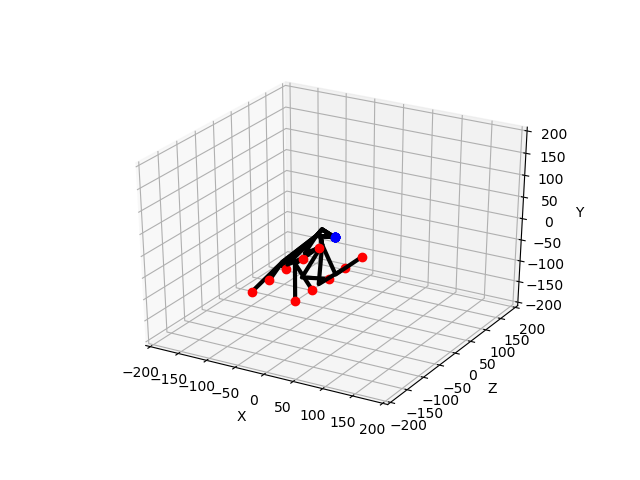

In [171]:
%matplotlib notebook
setupView()
for z in range(-100,150,50):
    drawLeg(calcLegPoints(x+25,y,z))
    drawLeg(calcLegPoints(x-50,y,z))

<IPython.core.display.Javascript object>


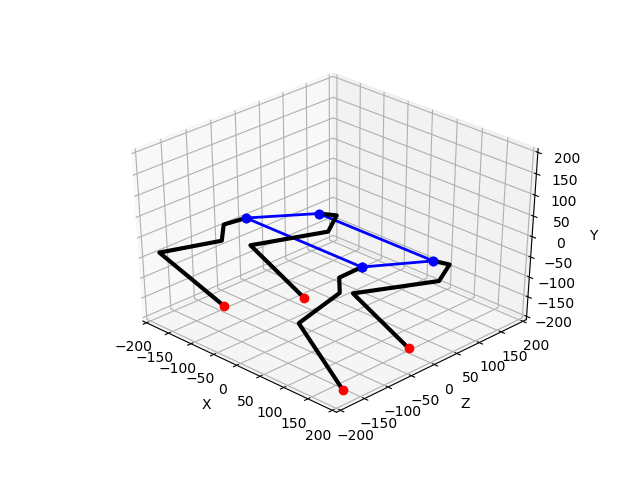

In [210]:
%matplotlib notebook
setupView()

L = 120
W = 90

def ikBody(omega,phi,psi,xm,ym,zm):

    """
    Calculate the four Transformation-Matrices for our Legs
    Rx=X-Axis Rotation Matrix
    Ry=Y-Axis Rotation Matrix
    Rz=Z-Axis Rotation Matrix
    Rxyz=All Axis Rotation Matrix
    T=Translation Matrix
    Tm=Transformation Matrix
    Trb,Trf,Tlb,Tlf=final Matrix for RightBack,RightFront,LeftBack and LeftFront
    """
    
    Rx = np.array([
        [1, 0, 0, 0], 
        [0, np.cos(omega), -np.sin(omega), 0],
        [0,np.sin(omega),np.cos(omega),0],
        [0,0,0,1]])

    Ry = np.array([
        [np.cos(phi),0, np.sin(phi), 0], 
        [0, 1, 0, 0],
        [-np.sin(phi),0, np.cos(phi),0],
        [0,0,0,1]])

    Rz = np.array([
        [np.cos(psi),-np.sin(psi), 0,0], 
        [np.sin(psi),np.cos(psi),0,0],
        [0,0,1,0],
        [0,0,0,1]])

    Rxyz=Rx@Ry@Rz

    T = np.array([[1,0,0,xm],[0,1,0,ym],[0,0,1,zm],[0,0,0,1]])

    Tm = Rxyz+T

    Trb = Tm @ np.array([
        [np.cos(math.pi/2),0,np.sin(math.pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(math.pi/2),0,np.cos(math.pi/2),W/2],
        [0,0,0,1]])

    Trf = Tm @ np.array([
        [np.cos(math.pi/2),0,np.sin(math.pi/2),L/2],
        [0,1,0,0],
        [-np.sin(math.pi/2),0,np.cos(math.pi/2),W/2],
        [0,0,0,1]])

    Tlf = Tm @ np.array([
        [np.cos(math.pi/2),0,np.sin(math.pi/2),L/2],
        [0,1,0,0],
        [-np.sin(math.pi/2),0,np.cos(math.pi/2),-W/2],
        [0,0,0,1]])

    Tlb = Tm @ np.array([
        [np.cos(math.pi/2),0,np.sin(math.pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(math.pi/2),0,np.cos(math.pi/2),-W/2],
        [0,0,0,1]])
    
    return (Tlf,Trf,Tlb,Trb,Tm)

omega =  math.pi/4 # Body xrot
phi =0#math.pi/4# Body YRot
psi = 0#math.pi/6 # Body ZRot

xm = 10
ym = 0
zm = 0

(Tlf,Trf,Tlb,Trb,Tm)=ikBody(omega,phi,psi,xm,ym,zm)

FP=[0,0,0,1]

CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]
    
plt.plot([CP[0][0],CP[1][0],CP[3][0], CP[2][0],CP[0][0]],
         [CP[0][2],CP[1][2],CP[3][2], CP[2][2],CP[0][2]],
         [CP[0][1],CP[1][1],CP[3][1], CP[2][1],CP[0][1]], 'bo-', lw=2)

# Invert local Z
m=np.array([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

p=calcLegPoints(0,-100,10)
p=[Trf@x for x in p]
drawLeg(p)

p=calcLegPoints(-10,-100,10)
p=[Trb@x for x in p]
drawLeg(p)

TP=np.array([40,-150,0,1])

p=calcLegPoints(TP[0],TP[1],TP[2])
p=[m@x for x in p]
p=[Tlf@x for x in p]
drawLeg(p)

p=calcLegPoints(0,-100,10)
p=[m@x for x in p]
p=[Tlb@x for x in p]
drawLeg(p)


ModuleNotFoundError: No module named 'scipy.spatial.transform'